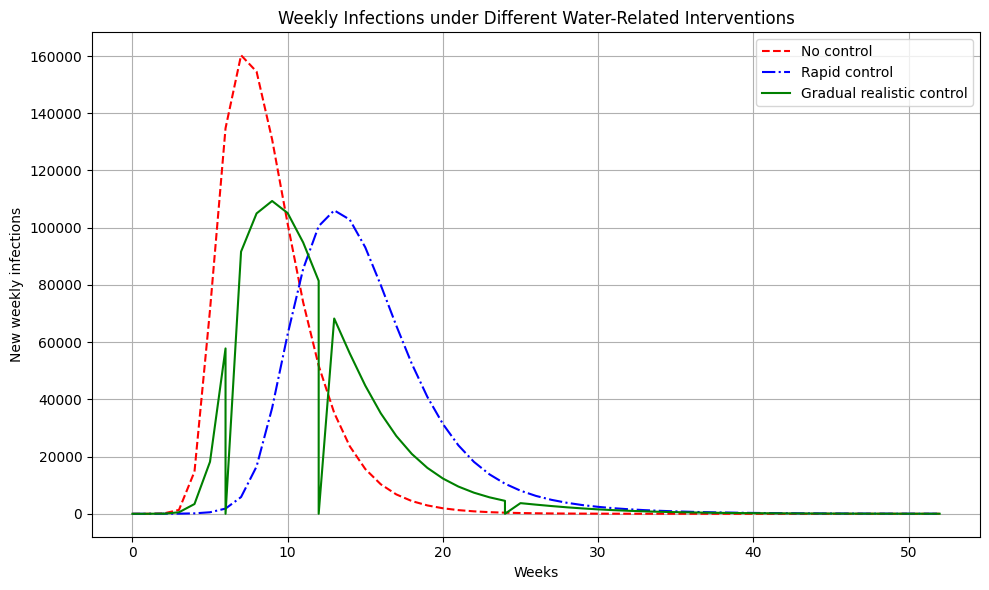

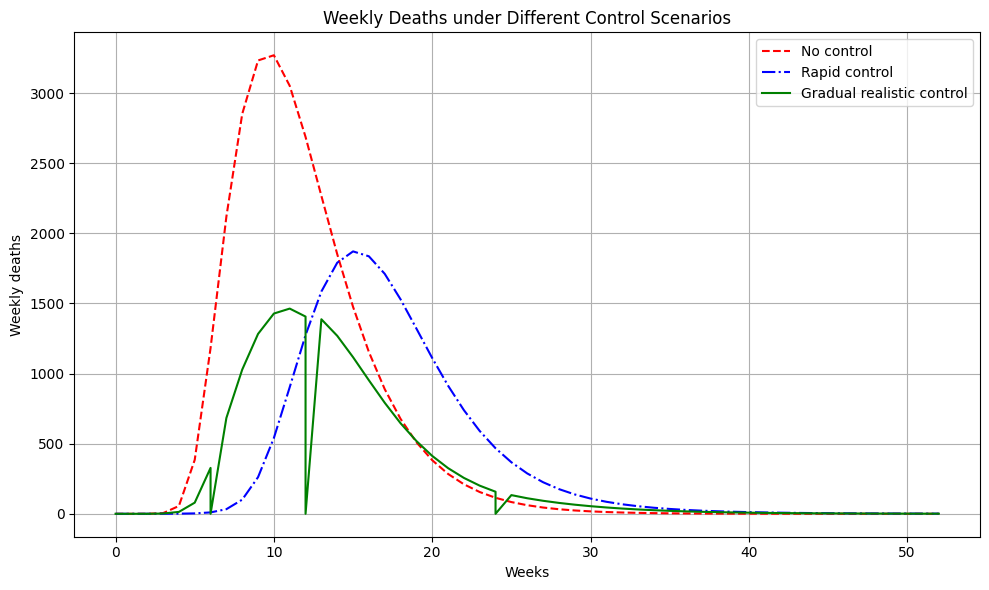

In [11]:
# =============================================
# SEIRC-C Epidemic Model with Environmental Compartment
# =============================================
# This version includes:
# - Original equations (unchanged)
# - Piecewise realistic control for sanitation, vaccination, and treatment
# - Gradual, rapid, and baseline scenarios
# - Infection and death plots
# =============================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.integrate import solve_ivp

# =====================================================
# 🧮 MODEL DEFINITION
# =====================================================

@dataclass
class Params:
    N: float
    beta1: float     # Direct transmission rate (person-to-person)
    beta2: float     # Environmental transmission rate (via contaminated water)
    sigma: float     # Incubation rate (E -> I)
    gamma: float     # Recovery rate
    mu: float        # Mortality rate
    delta: float     # Environmental decay rate
    eta: float       # Shedding rate (I → C)
    epsilon: float   # Environmental persistence rate
    kappa: float     # Environmental carrying capacity
    # Control parameters
    u_vac: float = 0.0
    u_san: float = 0.0
    u_treat: float = 0.0

@dataclass
class ControlGains:
    k_s_to_delta: float = 9.0
    k_s_to_beta2: float = 0.98
    k_s_to_eta: float = 0.6
    k_s_to_eps: float = 0.8
    k_v_to_beta: float = 1.0
    k_t_to_gamma: float = 3.0
    k_t_to_mu: float = 0.9

# =====================================================
# 📘 EQUATIONS (clearly written)
# =====================================================
# dS/dt = - (1 - u_vac) * [β1 * I/N + β2_eff * C/(C + κ)] * S
# dE/dt = (1 - u_vac) * [β1 * I/N + β2_eff * C/(C + κ)] * S - σ * E
# dI/dt = σ * E - γ_eff * I - μ_eff * I
# dR/dt = γ_eff * I
# dC/dt = η_eff * I * (1 - C/κ) + ε_eff * C - δ_eff * C
# dA/dt = σ * E
# dD/dt = μ_eff * I

# (where “eff” parameters are modified by controls)

# =====================================================
# 🔧 Effective parameter adjustment
# =====================================================

def _effective_params(p: Params, k: ControlGains):
    u_v, u_s, u_t = map(lambda x: float(np.clip(x, 0, 1)), [p.u_vac, p.u_san, p.u_treat])
    susc_scale = (1 - k.k_v_to_beta * u_v)
    delta_eff = p.delta * (1 + k.k_s_to_delta * u_s)
    beta2_eff = p.beta2 * max(0, 1 - k.k_s_to_beta2 * u_s)
    eta_eff   = p.eta * (1 - k.k_s_to_eta * u_s)
    eps_eff   = p.epsilon * (1 - k.k_s_to_eps * u_s)
    gamma_eff = p.gamma * (1 + k.k_t_to_gamma * u_t)
    mu_eff    = p.mu * (1 - k.k_t_to_mu * u_t)
    return dict(susc_scale=susc_scale, delta_eff=delta_eff, beta2_eff=beta2_eff,
                eta_eff=eta_eff, eps_eff=eps_eff, gamma_eff=gamma_eff, mu_eff=mu_eff)

# =====================================================
# 🧩 System of differential equations
# =====================================================

def rhs(t, y, p: Params, gains: ControlGains):
    S, E, I, R, C, A, D = y
    eff = _effective_params(p, gains)

    lambda_dir = p.beta1 * I / p.N
    lambda_env = eff["beta2_eff"] * C / (C + p.kappa)
    lambda_tot = eff["susc_scale"] * (lambda_dir + lambda_env)

    dS = -lambda_tot * S
    dE = lambda_tot * S - p.sigma * E
    dI = p.sigma * E - eff["gamma_eff"] * I - eff["mu_eff"] * I
    dR = eff["gamma_eff"] * I
    dC = eff["eta_eff"] * I * (1 - C / p.kappa) + eff["eps_eff"] * C - eff["delta_eff"] * C
    dA = p.sigma * E
    dD = eff["mu_eff"] * I

    return np.array([dS, dE, dI, dR, dC, dA, dD], dtype=float)

# =====================================================
# 🚀 Simulation function
# =====================================================

def simulate(t_weeks, y0, params: Params, gains: ControlGains):
    sol = solve_ivp(lambda t, y: rhs(t, y, params, gains),
                    (t_weeks[0], t_weeks[-1]), y0, t_eval=t_weeks,
                    rtol=1e-6, atol=1e-8, method="LSODA")
    S, E, I, R, C, A, D = sol.y
    A_diff = np.diff(A, prepend=A[0])
    D_diff = np.diff(D, prepend=D[0])
    return dict(t=sol.t, S=S, E=E, I=I, R=R, C=C,
                cum_inc=A, cum_deaths=D,
                weekly_cases=A_diff, weekly_deaths=D_diff)

# =====================================================
# 💡 SCENARIOS
# =====================================================

weeks = np.linspace(0, 52, 53)
N = 1_000_000
y0 = (N - 10, 10, 0, 0, 0, 0, 0)
params_base = Params(N=N, beta1=0.8, beta2=0.6, sigma=1/2, gamma=1/3,
                     mu=0.01, delta=0.2, eta=0.4, epsilon=0.05, kappa=5000)
gains = ControlGains()

# 🟥 1. Baseline (no control)
p1 = params_base
p1.u_san = 0.0; p1.u_vac = 0.0; p1.u_treat = 0.0
out_base = simulate(weeks, y0, p1, gains)

# 🟦 2. Rapid intervention
p2 = params_base
p2.u_san = 0.6; p2.u_vac = 0.0; p2.u_treat = 0.1
out_fast = simulate(weeks, y0, p2, gains)

# 🟩 3. Gradual, realistic control
segments = [(0, 2), (2, 6), (6, 12), (12, 24), (24, 52)]
schedule = {
    (0, 2):   {"u_san": 0.1, "u_vac": 0.0,  "u_treat": 0.05},
    (2, 6):   {"u_san": 0.3, "u_vac": 0.0,  "u_treat": 0.10},
    (6, 12):  {"u_san": 0.5, "u_vac": 0.1,  "u_treat": 0.20},
    (12, 24): {"u_san": 0.4, "u_vac": 0.1,  "u_treat": 0.15},
    (24, 52): {"u_san": 0.25,"u_vac": 0.05, "u_treat": 0.10},
}
weeks_total = []; weekly_cases_total = []; weekly_deaths_total = []
y_init = y0
for (start, end) in segments:
    t_seg = np.linspace(start, end, int(end - start) + 1)
    ctrl = schedule[(start, end)]
    p3 = params_base
    p3.u_san = ctrl["u_san"]
    p3.u_vac = ctrl["u_vac"]
    p3.u_treat = ctrl["u_treat"]
    out = simulate(t_seg, y_init, p3, gains)
    weeks_total.extend(out["t"])
    weekly_cases_total.extend(out["weekly_cases"])
    weekly_deaths_total.extend(out["weekly_deaths"])
    y_init = (out["S"][-1], out["E"][-1], out["I"][-1], out["R"][-1],
              out["C"][-1], out["cum_inc"][-1], out["cum_deaths"][-1])

weeks_total = np.array(weeks_total)
weekly_cases_total = np.array(weekly_cases_total)
weekly_deaths_total = np.array(weekly_deaths_total)

# =====================================================
# 📊 Plot: Weekly Infections Comparison
# =====================================================
plt.figure(figsize=(10, 6))
plt.plot(out_base["t"], out_base["weekly_cases"], 'r--', label="No control")
plt.plot(out_fast["t"], out_fast["weekly_cases"], 'b-.', label="Rapid control")
plt.plot(weeks_total, weekly_cases_total, 'g', label="Gradual realistic control")
plt.title("Weekly Infections under Different Water-Related Interventions")
plt.xlabel("Weeks")
plt.ylabel("New weekly infections")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# 📉 Plot: Weekly Deaths Comparison
# =====================================================
plt.figure(figsize=(10, 6))
plt.plot(out_base["t"], out_base["weekly_deaths"], 'r--', label="No control")
plt.plot(out_fast["t"], out_fast["weekly_deaths"], 'b-.', label="Rapid control")
plt.plot(weeks_total, weekly_deaths_total, 'g', label="Gradual realistic control")
plt.title("Weekly Deaths under Different Control Scenarios")
plt.xlabel("Weeks")
plt.ylabel("Weekly deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
